<a href="https://colab.research.google.com/github/ML-Guy/tutorials_transformers/blob/main/transformers_02_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Positional Encoding in Transformers

* The traditional approach of PE using sinusoidal positional encoding or learnable embedding adds positional information to the input embeddings before feeding them into the Transformer layers.
* Paper is "Rethinking Positional Encoding in Language Pre-training" by Wang et al. presents an alternative approach which incorporates positional information inside the attention blocks rather than at the input level.
* It inspired further development, most notebly, Relative PE (T5), RoPe (roformer, llama), AliBi (MPT) mechanisms.

In [ ]:
%pip install einops transformers rotary-embedding-torch wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-07-28 04:13:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2023-07-28 04:13:01 (36.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


# 1. Tokenizer

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenised_text=tokenizer.encode(text)
vocab = sorted(list(set(tokenised_text)))

# create a mapping from token_id to integers
stoi = { t:i for i,t in enumerate(vocab) }
itos = { i:t for i,t in enumerate(vocab) }
encode = lambda s: [stoi[t] for t in tokenizer.encode(s)] # encoder: take a string, output a list of integers
decode = lambda l: tokenizer.decode([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(f"vocab_size: {len(vocab)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


vocab_size: 11706


# 2. Data Loader

In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

def get_batch(split, device="cpu"):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# Config

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 4000 #5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 8
n_layer = 4
dropout = 0.2
# ------------
WAND_PROJECT="Transformers - PosEmbeddings"
WAND_MODE="online"
# WAND_MODE="disabled"

# ------------
vocab_size = len(vocab)
torch.manual_seed(1337)

# 4. Vanilla Transformer Model

In [ ]:
from einops import rearrange
exp_name="vanilla-transformer"

class MultiHeadAttention(nn.Module):
    """ multi head of self-attention """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size

        self.key = nn.Linear(head_size, head_size, bias=False)
        self.query = nn.Linear(head_size, head_size, bias=False)
        self.value = nn.Linear(head_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout_wei = nn.Dropout(dropout)
        n_embd= num_heads*head_size
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout_proj = nn.Dropout(dropout)


    def forward(self, x):
        # Reshape the tensor to B N T H for N heads
        B,T,C = x.shape
        x = rearrange(x, 'B T (N H) -> B N T H', N=self.num_heads)

        k = self.key(x)   # (B,N,T,H)
        q = self.query(x) # (B,N,T,H)

        # compute attention scores \
        wei = torch.einsum("BNQH, BNKH -> BNQK", q,k) * self.head_size**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout_wei(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,N,T,H)
        out = torch.einsum("BNTS, BNSH -> BNTH", wei, v)

        # concat and mix N Heads
        out = rearrange(out, 'B N T H -> B T (N H)')
        out = self.dropout_proj(self.proj(out))
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerSeq2Seq(nn.Module):
    def __init__(self):
        super().__init__()

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


class TransformerModel(TransformerSeq2Seq):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # https://paperswithcode.com/method/weight-tying
        self.token_embedding_table.weight = self.lm_head.weight

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # Position Embedding is calculated in beginning and added to tokens
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)

        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss



# Train and Evaluate

In [ ]:
def model_setup(TransformerModel):
  wandb.init(project=WAND_PROJECT, name=exp_name, mode=WAND_MODE)

  model = TransformerModel()
  model = model.to(device)
  model = torch.compile(model)
  # print the number of parameters in the model
  print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
  wandb.log({"model_parameters": sum(p.numel() for p in model.parameters())})

  # create a PyTorch optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  return model, optimizer

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, device=device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


model, optimizer = model_setup(TransformerModel)

In [ ]:
def train(model, optimizer, max_iters):
  if not model.training:
    model.train()
    print("Enabled Training mode: ",model.training)

  for iter in range(max_iters):

      # every once in a while evaluate the loss on train and val sets
      if iter % eval_interval == 0 or iter == max_iters - 1:
          losses = estimate_loss(model)
          print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
          wandb.log({"loss/train": losses['train'], "loss/val": losses['val']}, step=iter)

      # sample a batch of data
      xb, yb = get_batch('train', device=device)

      # evaluate the loss
      logits, loss = model(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

  wandb.finish()

train(model, optimizer, max_iters)

step 0: train loss 9.5550, val loss 9.5406


[2023-07-28 04:23:29,480] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:31,330] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:32,067] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:33,417] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:33,608] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:33,880] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:34,444] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:34,632] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:34,943] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:23:3

step 100: train loss 6.4151, val loss 6.4614
step 200: train loss 6.3673, val loss 6.4663
step 300: train loss 6.3845, val loss 6.4503
step 400: train loss 6.1444, val loss 6.2467
step 500: train loss 5.9522, val loss 6.1078
step 600: train loss 5.8916, val loss 5.9866
step 700: train loss 5.7892, val loss 5.9164
step 800: train loss 5.7198, val loss 5.8582
step 900: train loss 5.6753, val loss 5.8274
step 1000: train loss 5.5624, val loss 5.7493
step 1100: train loss 5.4842, val loss 5.6581
step 1200: train loss 5.3845, val loss 5.6400
step 1300: train loss 5.3324, val loss 5.5691
step 1400: train loss 5.2878, val loss 5.5344
step 1500: train loss 5.2201, val loss 5.4774
step 1600: train loss 5.1997, val loss 5.4590
step 1700: train loss 5.1358, val loss 5.4159
step 1800: train loss 5.0806, val loss 5.4337
step 1900: train loss 5.0268, val loss 5.3688
step 2000: train loss 5.0209, val loss 5.3660
step 2100: train loss 4.9487, val loss 5.3243
step 2200: train loss 4.9334, val loss 5.32

In [ ]:
# generate from the model
model.eval()
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))

!

DUKE VINCENTIO:
I't be satisfied,
As friend to baw morn'd calf?

ESCALUS:
L LEWIS XI:
Sub'Tis no tedious sights, had a remove
That Eve we it here I shall like an Nell'd.

DUKE VINCENTIO:
An he bid me to- firmads;
Whom Lewis and in one king; which 'And I think
Freshly gracious lie with his great wed again.

QUEEN MARGARENCE:
What, on the part trouble me, and jested painted by one foxs,
Made one usurp'd a lasting opinion-kind brother gave me,
And this the like my browsals belly,
Wh hedgericire in his land's day,
Whose Apollo, where the rest incluck'd;
countryforth I were sugar, keeps
But with King cry 'How I enjoy'd, if they freely come all to dry but by his ears.

ESCALUS:
Let, solace presently, when
Of all in that we came care, my beating and loved thy wit
Only and thy tongue, from all an wicked cries in love.
Love I hear him in overwhelming car, if reason.
What's not, I were inch of weeping
By the great gaoler souls to his brotherhood;
Which now we have been much or bunchiers,
More

# Integrated Positional Embedding
$$att = softmax(\frac{1}{√({dim} )}(Q K^T+ Q P))$$
<script type="text/javascript" src="https://www.hostmath.com/Math/MathJax.js?config=OK"></script>

 P is learnable position embedding, learning unique representation for each position.

In [ ]:
exp_name="integrated-pos-embedding"

class MultiHeadAttention(nn.Module):
    """ multi head of self-attention """

    def __init__(self, num_heads, head_size, shared_head=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.shared_head = shared_head

        self.key = nn.Linear(head_size, head_size, bias=False)
        self.query = nn.Linear(head_size, head_size, bias=False)
        self.value = nn.Linear(head_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        if self.shared_head:
          self.pos_emb = nn.Parameter(torch.randn(block_size, head_size))
        else:
          self.pos_emb = nn.Parameter(torch.randn(num_heads, block_size, head_size))

        self.dropout_wei = nn.Dropout(dropout)
        n_embd= num_heads*head_size
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout_proj = nn.Dropout(dropout)


    def forward(self, x):
        # Reshape the tensor to B N T H for N heads
        B,T,C = x.shape
        x = rearrange(x, 'B T (N H) -> B N T H', N=self.num_heads)

        k = self.key(x)   # (B,N,T,H)
        q = self.query(x) # (B,N,T,H)

        # compute attention scores
        q = q * self.head_size**-0.5
        wei = torch.einsum("BNTH, BNSH -> BNTS", q,k)

        # Position Embedding
        if self.shared_head:
          p_wei = torch.einsum("BNTH, SH-> BNTS" ,q,self.pos_emb[:T])
        else:
          p_wei = torch.einsum("BNTH, NSH-> BNTS" ,q,self.pos_emb[:,:T,:])

        wei += p_wei

        # final attention and value computation
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout_wei(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,N,T,H)
        out = torch.einsum("BNTS, BNSH -> BNTH", wei, v)

        # concat and mix N Heads
        out = rearrange(out, 'B N T H -> B T (N H)')
        out = self.dropout_proj(self.proj(out))
        return out


In [ ]:
class TransformerModel(TransformerSeq2Seq):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # https://paperswithcode.com/method/weight-tying
        self.token_embedding_table.weight = self.lm_head.weight


    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        x = self.token_embedding_table(idx) # (B,T,C)

        # x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

In [ ]:
model, optimizer = model_setup(TransformerModel)
train(model, optimizer, max_iters)

# Relative Bias (T5)
> Instead of using a fixed embedding for each position, relative position embeddings produce a different learned embedding according to the offset between the “key” and “query” being compared in the self-attention mechanism. We use a simplified form of position embeddings where each “embedding” is simply a scalar that is added to the corresponding logit used for computing the attention weights. For efficiency, we also share the position embedding parameters across all layers in our model, though within a given layer each attention head
uses a different learned position embedding. Typically, a fixed number of embeddings are learned, each corresponding to a range of possible key-query offsets.

[T5 Paper](https://arxiv.org/pdf/1910.10683.pdf)
[Code Implementation](https://github.com/huggingface/transformers/blob/main/src/transformers/models/t5/modeling_t5.py#L435)

$$att = softmax(\frac{1}{√({dim} )}(Q K^T+ PosBias_{rel}))$$
<script type="text/javascript" src="https://www.hostmath.com/Math/MathJax.js?config=OK"></script>

P is learnable position embedding, learning unique representation for each position.

Original T5 implemetation utilised more complex position binning based on linear and logrithmic relative distance for scaling to larger context.

Relative Position of Query to Keys:
$$
\begin{align*}
\text{Query}
\begin{bmatrix} & \text{Key} \\
0 & 1 & 2 & \ldots & k-1\\
-1 & 0 & 1 & \ldots & k-2\\
-2 & -1 & 0 & \ldots & k-2\\
\vdots & & & \\
-(k-1) & -(k-2) & -(k-3) & \ldots & 0
\end{bmatrix}
\end{align*}
$$


All Relative Postions = $[-k+1, ...,  -2, -1, 0, 1, 2, ..., k-1]$

* Basic understanding and generic relative_to_absolute implementation can be done based on [Extra Section](https://colab.research.google.com/drive/12w_nu0NHDP73M9xJHxahqDWtJpKb2yvM#scrollTo=3ed8Ri3r98DF&line=1&uniqifier=1).


* Following ***relative_to_absolute*** code is borrowed from lucidrains for non-causal implementation

 https://github.com/lucidrains/bottleneck-transformer-pytorch/blob/main/bottleneck_transformer_pytorch/bottleneck_transformer_pytorch.py#L21

* Good reference for more optimised Causal Attention as introduced by [Shaw et al (2018)](https://arxiv.org/pdf/1803.02155.pdf) and refined by [Huang et al (2018)](https://arxiv.org/pdf/1809.04281.pdf) -  https://jaketae.github.io/study/relative-positional-encoding/


In [ ]:
import torch
import torch.nn as nn
from einops import rearrange,repeat

def relative_to_absolute(q):
    """
    Converts the dimension that is specified from the axis
    from relative distances (with length 2*tokens-1) to absolute distance (length tokens)
      Input: [bs, heads, length, 2*length - 1]
      Output: [bs, heads, length, length]
    """
    b, h, l, _, device, dtype = *q.shape, q.device, q.dtype
    dd = {'device': device, 'dtype': dtype}
    col_pad = torch.zeros((b, h, l, 1), **dd)
    x = torch.cat((q, col_pad), dim=3)  # zero pad 2l-1 to 2l
    flat_x = rearrange(x, 'b h l c -> b h (l c)')
    flat_pad = torch.zeros((b, h, l - 1), **dd)
    flat_x_padded = torch.cat((flat_x, flat_pad), dim=2)
    final_x = flat_x_padded.reshape(b, h, l + 1, 2 * l - 1)
    final_x = final_x[:, :, :l, (l - 1):]
    return final_x

In [ ]:
x = torch.Tensor([[[[-3,-2,-1,0,1,2,3]]*4]])
print(x.shape)
x

torch.Size([1, 1, 4, 7])


tensor([[[[-3., -2., -1.,  0.,  1.,  2.,  3.],
          [-3., -2., -1.,  0.,  1.,  2.,  3.],
          [-3., -2., -1.,  0.,  1.,  2.,  3.],
          [-3., -2., -1.,  0.,  1.,  2.,  3.]]]])

In [ ]:
y = relative_to_absolute(x)
print(y.shape)
y

torch.Size([1, 1, 4, 4])


tensor([[[[ 0.,  1.,  2.,  3.],
          [-1.,  0.,  1.,  2.],
          [-2., -1.,  0.,  1.],
          [-3., -2., -1.,  0.]]]])

In [ ]:
exp_name="relative-bias"
class MultiHeadAttention(nn.Module):
    """ multi head of self-attention """

    def __init__(self, num_heads, head_size, shared_head=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.shared_head = shared_head

        self.key = nn.Linear(head_size, head_size, bias=False)
        self.query = nn.Linear(head_size, head_size, bias=False)
        self.value = nn.Linear(head_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        if self.shared_head:
          self.pos_emb = nn.Parameter(torch.randn(2*block_size - 1)) # For causal, size can be of block_size only
        else:
          self.pos_emb = nn.Parameter(torch.randn(num_heads, 2*block_size - 1))

        self.dropout_wei = nn.Dropout(dropout)
        n_embd= num_heads*head_size
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout_proj = nn.Dropout(dropout)


    def forward(self, x):
        # Reshape the tensor to B N T H for N heads
        B,T,C = x.shape
        x = rearrange(x, 'B T (N H) -> B N T H', N=self.num_heads)

        k = self.key(x)   # (B,N,T,H)
        q = self.query(x) # (B,N,T,H)

        # compute attention scores
        q = q * self.head_size**-0.5
        wei = torch.einsum("BNTH, BNSH -> BNTS", q,k)

        # Position Bias
        if self.shared_head:
          p_wei = relative_to_absolute(repeat(
              self.pos_emb ,
              "S -> B N T S",
              B=1, N=1, T=block_size))[:,:,:T, :T]
        else:
           p_wei = relative_to_absolute(repeat(
              self.pos_emb ,
              "N S -> B N T S",
              B=1, T=block_size))[:,:,:T, :T]

        wei += p_wei

        # final attention and value computation
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout_wei(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,N,T,H)
        out = torch.einsum("BNTS, BNSH -> BNTH", wei, v)

        # concat and mix N Heads
        out = rearrange(out, 'B N T H -> B T (N H)')
        out = self.dropout_proj(self.proj(out))
        return out



In [ ]:
model, optimizer = model_setup(TransformerModel)
train(model, optimizer, max_iters)

# Relative Position Embeddings
$$att = softmax(\frac{1}{√({dim} )}(Q K^T+ Q P_{rel}))$$
<script type="text/javascript" src="https://www.hostmath.com/Math/MathJax.js?config=OK"></script>

P is learnable position embedding, learning unique representation for each relative pair of position.

In [ ]:
from einops import rearrange
exp_name="relative-pos-embeddings"

class MultiHeadAttention(nn.Module):
    """ multi head of self-attention """

    def __init__(self, num_heads, head_size, shared_head=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.shared_head = shared_head

        self.qkv = nn.Linear(head_size, 3*head_size, bias=False) # stacked QKV
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        if self.shared_head:
          self.pos_emb = nn.Parameter(torch.randn(2*block_size - 1, head_size)) # For causal, size can be of block_size only
        else:
          self.pos_emb = nn.Parameter(torch.randn(num_heads, 2*block_size - 1, head_size))

        self.dropout_wei = nn.Dropout(dropout)
        n_embd= num_heads*head_size
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout_proj = nn.Dropout(dropout)


    def forward(self, x):
        # Reshape the tensor to B N T H for N heads
        B,T,C = x.shape
        x = rearrange(x, 'B T (N H) -> B N T H', N=self.num_heads)

        q,k,v = rearrange(self.qkv(x), "B N T (n H)-> n B N T H", n=3)    #(B,N,T,3H) - > 3 B N T H

        # compute attention scores \
        wei = torch.einsum("BNTH, BNSH -> BNTS", q,k) * self.head_size**-0.5

        # Position Bias
        if self.shared_head:
            p_wei = relative_to_absolute(torch.einsum("BNTH, SH -> BNTS", q, self.pos_emb))[:,:,:T, :T]  # QP
        else:
            p_wei = relative_to_absolute(torch.einsum("BNTH, NSH -> BNTS", q, self.pos_emb))[:,:,:T, :T]

        wei += p_wei

        # final attention and value computation
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout_wei(wei)
        # perform the weighted aggregation of the values
        out = torch.einsum("BNTS, BNSH -> BNTH", wei, v)


        # concat and mix N Heads
        out = rearrange(out, 'B N T H -> B T (N H)')
        out = self.dropout_proj(self.proj(out))
        return out

In [ ]:
model, optimizer = model_setup(TransformerModel)
train(model, optimizer, max_iters)

#  Rotary Position Embedding (RoPE)
* The computation of the relative positional bias (T5) requires constructing the full attention matrix between all pairs of positions in the input sequence, which has a quadratic time complexity. While this is feasible for small input sequences, it becomes computationally expensive for longer sequences.
* It can be used when using many of the efficient alternatives to softmax attention, including kernelized variants like FAVOR+ dont compute full attention matrix.
* RoPE encode position information of tokens with a rotation matrix that naturally incorporates explicit relative position dependency with attention calculations.
* It has been widely used in llama, PaLM, Dolly and other latest transformer models

[RoPE library Implemetation](https://github.com/lucidrains/rotary-embedding-torch)

[LLAMA Code Implementation](https://github.com/juncongmoo/pyllama/blob/main/llama/model_single.py)

[eleutherAI Blog ](https://blog.eleuther.ai/rotary-embeddings/)


In [ ]:
from einops import rearrange
from rotary_embedding_torch import RotaryEmbedding
exp_name="RoPE"

class MultiHeadAttention(nn.Module):
    """ multi head of self-attention """

    def __init__(self, num_heads, head_size, shared_head=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.shared_head = shared_head

        self.qkv = nn.Linear(head_size, 3*head_size, bias=False) # stacked QKV
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.rotary_emb =  RotaryEmbedding(
            dim = head_size,
            use_xpos = True   # set this to True to make rotary embeddings extrapolate better to sequence lengths greater than the one used at training time
            )

        self.dropout_wei = nn.Dropout(dropout)
        n_embd= num_heads*head_size
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout_proj = nn.Dropout(dropout)


    def forward(self, x):
        # Reshape the tensor to B N T H for N heads
        B,T,C = x.shape
        x = rearrange(x, 'B T (N H) -> B N T H', N=self.num_heads)

        q,k,v = rearrange(self.qkv(x), "B N T (n H)-> n B N T H", n=3)    #(B,N,T,3H) - > 3 B N T H

        # Apply RoPE
        q, k = self.rotary_emb.rotate_queries_and_keys(q, k)

        # compute attention scores - Flash attention
        out = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=dropout if self.training else 0, is_causal=True)

        # concat and mix N Heads
        out = rearrange(out, 'B N T H -> B T (N H)')
        out = self.dropout_proj(self.proj(out))
        return out

In [ ]:
model, optimizer = model_setup(TransformerModel)
train(model, optimizer, max_iters)

# Align and Bias (AliBi)

Instead, computing the attention between a certain key and query, ALiBi penalizes the attention value that that query can assign to the key depending on how far away the key and query are. So when a key and query are close by, the penalty is very low, and when they are far away, the penalty is very high.

The biases decrease linearly in the log scale and each head has a different slope.

It is very fast and and used in MPT. It outperforms Rotary embeddings in accuracy when evaluating sequences that are longer than the ones the model was trained on (extrapolation).

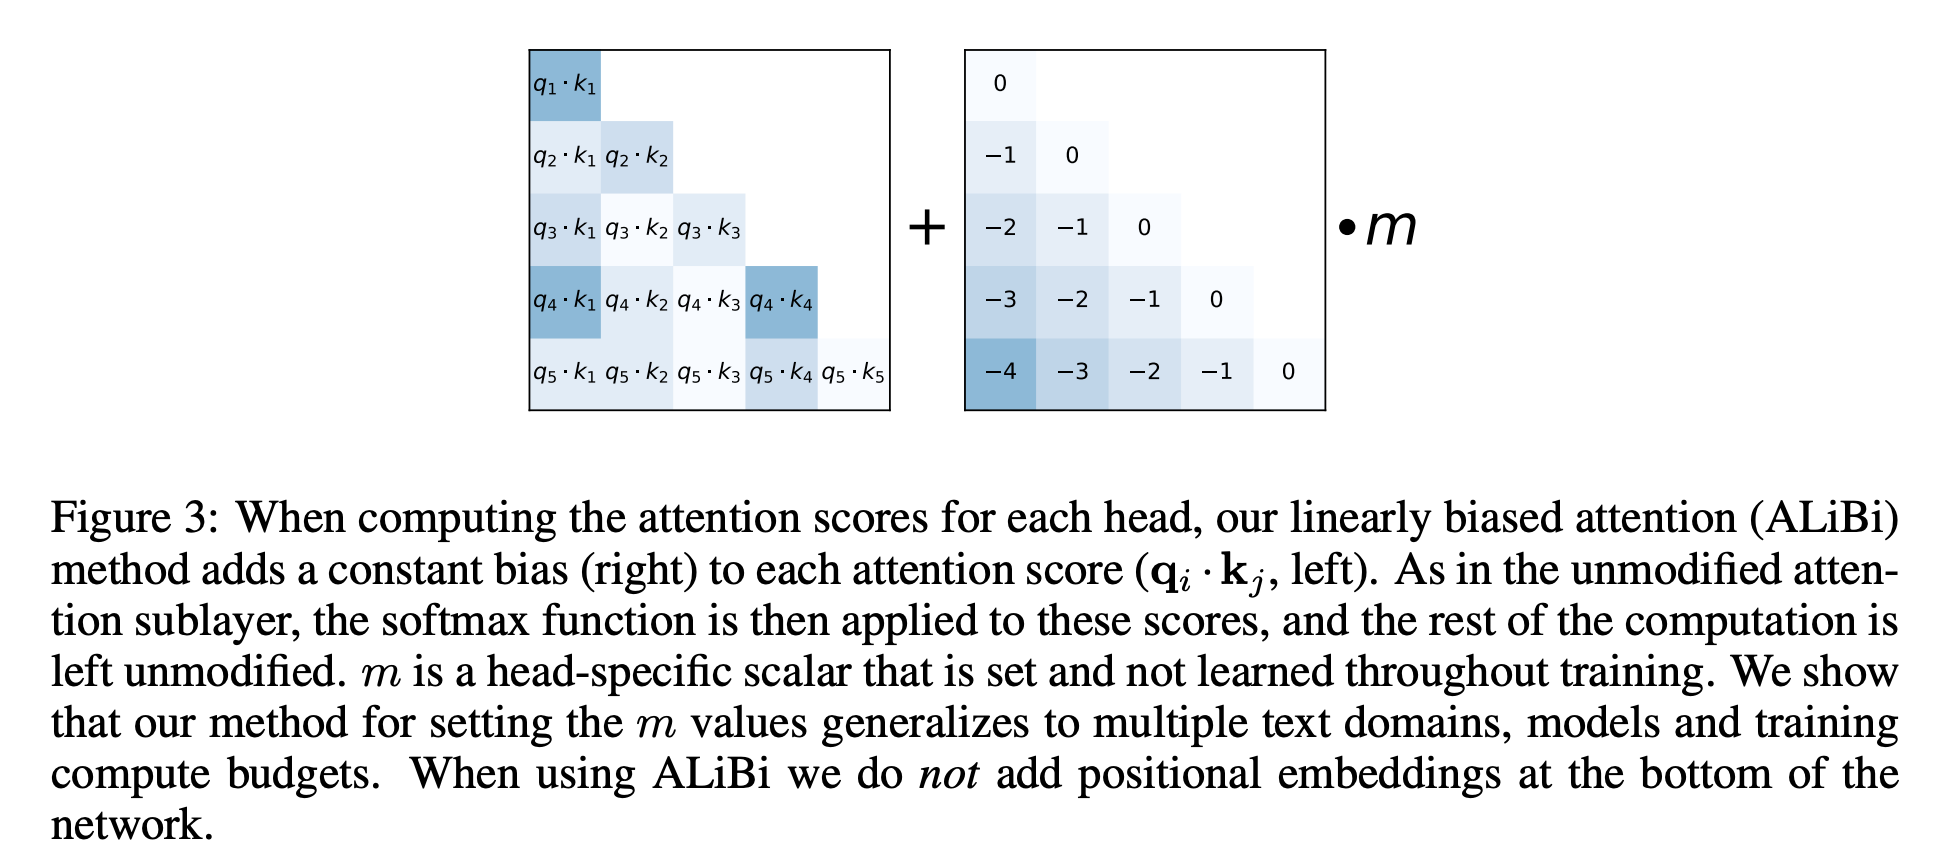

In [ ]:
import math
# Code reference from https://nn.labml.ai/transformers/alibi/index.html with some changes

def get_slopes(n_heads: int):
    n = 2 ** math.floor(math.log2(n_heads))
    m_0 = 2.0 ** (-8.0 / n)
    m = torch.pow(m_0, torch.arange(1, 1 + n))
    if n < n_heads:
        m_hat_0 = 2.0 ** (-4.0 / n)
        m_hat = torch.pow(m_hat_0, torch.arange(1, 1 + 2 * (n_heads - n), 2))
        m = torch.cat([m, m_hat])

    return m

def get_distance(seq_len: int):
    # We use cumsum on causal mask to calculate distance pattern.
    # As diagonal elements of distance pattern are zero, we use causal mask of N+1
    mask = torch.tril(torch.ones(seq_len+1,seq_len+1))
    distance=mask.cumsum(0)[:-1,1:]
    return distance


@torch.no_grad()
def get_alibi_biases(n_heads: int, seq_len: int, device=device):

    m = get_slopes(n_heads).to(device)
    distance = get_distance(seq_len).to(device)

    # Multiply them pair-wise to get the AliBi bias matrix
    biases = distance[None,:, :] * (m[:,None, None] *-1)

    return biases


In [ ]:
m=get_slopes(8)
m

tensor([0.5000, 0.2500, 0.1250, 0.0625, 0.0312, 0.0156, 0.0078, 0.0039])

In [ ]:
get_distance(10)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 2., 1., 0., 0., 0., 0., 0., 0., 0.],
        [4., 3., 2., 1., 0., 0., 0., 0., 0., 0.],
        [5., 4., 3., 2., 1., 0., 0., 0., 0., 0.],
        [6., 5., 4., 3., 2., 1., 0., 0., 0., 0.],
        [7., 6., 5., 4., 3., 2., 1., 0., 0., 0.],
        [8., 7., 6., 5., 4., 3., 2., 1., 0., 0.],
        [9., 8., 7., 6., 5., 4., 3., 2., 1., 0.]])

In [ ]:
get_alibi_biases(8, 3)

tensor([[[-0.0000, -0.0000, -0.0000],
         [-0.5000, -0.0000, -0.0000],
         [-1.0000, -0.5000, -0.0000]],

        [[-0.0000, -0.0000, -0.0000],
         [-0.2500, -0.0000, -0.0000],
         [-0.5000, -0.2500, -0.0000]],

        [[-0.0000, -0.0000, -0.0000],
         [-0.1250, -0.0000, -0.0000],
         [-0.2500, -0.1250, -0.0000]],

        [[-0.0000, -0.0000, -0.0000],
         [-0.0625, -0.0000, -0.0000],
         [-0.1250, -0.0625, -0.0000]],

        [[-0.0000, -0.0000, -0.0000],
         [-0.0312, -0.0000, -0.0000],
         [-0.0625, -0.0312, -0.0000]],

        [[-0.0000, -0.0000, -0.0000],
         [-0.0156, -0.0000, -0.0000],
         [-0.0312, -0.0156, -0.0000]],

        [[-0.0000, -0.0000, -0.0000],
         [-0.0078, -0.0000, -0.0000],
         [-0.0156, -0.0078, -0.0000]],

        [[-0.0000, -0.0000, -0.0000],
         [-0.0039, -0.0000, -0.0000],
         [-0.0078, -0.0039, -0.0000]]], device='cuda:0')

In [ ]:
from einops import rearrange
exp_name="ALiBi"

class MultiHeadAttention(nn.Module):
    """ multi head of self-attention with ALiBi"""

    def __init__(self, num_heads, head_size, shared_head=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.shared_head = shared_head

        self.qkv = nn.Linear(head_size, 3*head_size, bias=False) # stacked QKV
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # To cache AliBi the biases
        self.alibi_biases = None

        self.dropout_wei = nn.Dropout(dropout)
        n_embd= num_heads*head_size
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout_proj = nn.Dropout(dropout)


    def forward(self, x):
        # Reshape the tensor to B N T H for N heads
        B,T,C = x.shape
        x = rearrange(x, 'B T (N H) -> B N T H', N=self.num_heads)

        q,k,v = rearrange(self.qkv(x), "B N T (n H)-> n B N T H", n=3)    #(B,N,T,3H) - > 3 B N T H

        # compute attention scores \
        wei = torch.einsum("BNTH, BNSH -> BNTS", q,k) * self.head_size**-0.5

        # Position Bias
        ## Create AliBi biases if it's not cached
        if self.alibi_biases is None or self.alibi_biases.shape[1] < T:
            self.alibi_biases = get_alibi_biases(self.num_heads, seq_len=T)

        # Add AliBi biases to attention scores.
        # ALiBi biases has shape `[n_heads, seq_len, seq_len]`
        wei += self.alibi_biases[None, :, :T, :T]

        # final attention and value computation
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout_wei(wei)
        # perform the weighted aggregation of the values
        out = torch.einsum("BNTS, BNSH -> BNTH", wei, v)


        # concat and mix N Heads
        out = rearrange(out, 'B N T H -> B T (N H)')
        out = self.dropout_proj(self.proj(out))
        return out

In [ ]:
model, optimizer = model_setup(TransformerModel)
train(model, optimizer, max_iters)

wandb: Currently logged in as: saurabh5228. Use `wandb login --relogin` to force relogin


0.911802 M parameters
step 0: train loss 9.6408, val loss 9.6231


[2023-07-28 04:59:03,415] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:03,624] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:03,881] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:04,517] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:04,729] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:05,026] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:05,669] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:05,888] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:06,161] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-28 04:59:0

step 100: train loss 6.2136, val loss 6.2760
step 200: train loss 5.8172, val loss 5.9437
step 300: train loss 5.4904, val loss 5.6388
step 400: train loss 5.2231, val loss 5.4420
step 500: train loss 5.0816, val loss 5.2844
step 600: train loss 4.9334, val loss 5.1729
step 700: train loss 4.8362, val loss 5.1252
step 800: train loss 4.7153, val loss 5.0880
step 900: train loss 4.7059, val loss 5.0322
step 1000: train loss 4.5785, val loss 4.9738
step 1100: train loss 4.5557, val loss 4.9768
step 1200: train loss 4.4948, val loss 4.9530
step 1300: train loss 4.4500, val loss 4.9105
step 1400: train loss 4.4366, val loss 4.8991
step 1500: train loss 4.4013, val loss 4.8822
step 1600: train loss 4.3467, val loss 4.8723
step 1700: train loss 4.3249, val loss 4.8324
step 1800: train loss 4.2808, val loss 4.8033
step 1900: train loss 4.2520, val loss 4.7816
step 2000: train loss 4.2222, val loss 4.7940
step 2100: train loss 4.1770, val loss 4.8222
step 2200: train loss 4.1840, val loss 4.81

loss/train,█▇▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model_parameters,▁
loss/train,3.91483
loss/val,4.8061
model_parameters,911802


# Landmark Attention
Implementation Details https://github.com/epfml/landmark-attention

# What's Next?

Next, we will take a  look at several advancements have been made in Efficient attention mechanisms such as Sparse Attention(BIG BIRD), FAVOR+ (Performer), MultiQuery Attention, and Longformer(Sliding Attention).

# Extra
## Relative to Absolute conversion

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
k = 5
causal = False

end =  0 if causal else k-1
w= np.arange(-k+1,end+1)
l = len(w)
w,l

(array([-4, -3, -2, -1,  0,  1,  2,  3,  4]), 9)

In [ ]:
w1=np.concatenate([w,[-np.inf]])
w1

array([ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf])

In [ ]:
w1 = np.repeat(w1[np.newaxis, :], l, axis=0)
w1

array([[ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
       [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf]])

In [ ]:
w1, w1.shape

(array([[ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf],
        [ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf]]),
 (9, 10))

In [ ]:
w1 = w1.reshape((l+1,l))
w1

array([[ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.],
       [-inf,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.],
       [  4., -inf,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.],
       [  3.,   4., -inf,  -4.,  -3.,  -2.,  -1.,   0.,   1.],
       [  2.,   3.,   4., -inf,  -4.,  -3.,  -2.,  -1.,   0.],
       [  1.,   2.,   3.,   4., -inf,  -4.,  -3.,  -2.,  -1.],
       [  0.,   1.,   2.,   3.,   4., -inf,  -4.,  -3.,  -2.],
       [ -1.,   0.,   1.,   2.,   3.,   4., -inf,  -4.,  -3.],
       [ -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf,  -4.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4., -inf]])

In [ ]:
if not causal:
  w1 = w1[:k,k-1:]
  w1

In [ ]:
if causal:
  w1 =np.concatenate([w1[2:],w1[0:1,:]])
  causal_mask = np.tril(np.ones((k, k)))
  w1 = np.where(causal_mask == 0, -np.inf, w1)
  w1

In [ ]:
w1

array([[ 0.,  1.,  2.,  3.,  4.],
       [-1.,  0.,  1.,  2.,  3.],
       [-2., -1.,  0.,  1.,  2.],
       [-3., -2., -1.,  0.,  1.],
       [-4., -3., -2., -1.,  0.]])